# Part 2: Python Ecosystem for EO
     
## Core Python Libraries Overview

Python has become the lingua franca of EO processing through powerful libraries. Before diving into the details, let's revisit data cubes and how we can represent them in Python. EO data cubes in Python are typically represented as labeled multidimensional arrays that integrate data values, coordinates, and metadata. Consider, for example, a 6x7 raster with 4 spectral bands collected over 3 time points. This structured representation allows efficient and intuitive access to complex EO datasets.

```{figure} https://openeo.org/assets/img/dc_timeseries.c2c7a902.png
:name: An examplary raster datacube with 4 dimensions: x, y, bands and time.
:width: 900px
An examplary raster datacube with 4 dimensions: x, y, bands and time.
```

## Data cubes and Lazy data loading with Xarray

When accessing data through an API or cloud service, data is often **lazily** loaded. This means that initially only the metadata is retrieved, allowing us to understand the data’s dimensions, spatial and temporal extents, available spectral bands, and additional context without downloading the entire dataset.

[Xarray](https://xarray.dev) supports this approach effectively, providing a powerful interface to open, explore, and manipulate large EO data cubes efficiently.

Let's open an example dataset to explore these capabilities.

:::{note} xarray-eopf
**xarray-eopf** is a Python package that extends **xarray** with a custom backend called "eopf-zarr". This backend enables seamless access to ESA EOPF data products stored in the Zarr format, presenting them as analysis-ready data structures.

This notebook demonstrates how to use the `xarray-eopf` backend to explore and analyze EOPF Zarr datasets. It highlights the key features currently supported by the backend.

- 🐙 GitHub: [EOPF Sample Service – xarray-eopf](https://github.com/EOPF-Sample-Service/xarray-eopf)
- 📘 Documentation: [xarray-eopf Docs](https://eopf-sample-service.github.io/xarray-eopf/)
:::

In [1]:
import xarray as xr

In [2]:
xr.set_options(display_expand_attrs=False)

In [3]:
path = (
    "https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202505-s02msil2a/18/products"
    "/cpm_v256/S2B_MSIL2A_20250518T112119_N0511_R037_T29RLL_20250518T140519.zarr"
)


In [4]:
ds = xr.open_dataset(
    path,
    engine="eopf-zarr",
    op_mode="native",
    chunks={},
    group_sep="/",
    variables="quality/l2a_quicklook/r60m/*",
)
ds

<xarray.Dataset> Size: 10MB
Dimensions:                          (quality/l2a_quicklook/r60m/band: 3,
                                      quality/l2a_quicklook/r60m/y: 1830,
                                      quality/l2a_quicklook/r60m/x: 1830)
Coordinates:
  * quality/l2a_quicklook/r60m/band  (quality/l2a_quicklook/r60m/band) int64 24B ...
  * quality/l2a_quicklook/r60m/x     (quality/l2a_quicklook/r60m/x) int64 15kB ...
  * quality/l2a_quicklook/r60m/y     (quality/l2a_quicklook/r60m/y) int64 15kB ...
Data variables:
    quality/l2a_quicklook/r60m/tci   (quality/l2a_quicklook/r60m/band, quality/l2a_quicklook/r60m/y, quality/l2a_quicklook/r60m/x) uint8 10MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
Attributes: (2)

## Quick Visualisation

As an example, we plot the quicklook image to view the RGB image.

In [5]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [6]:
ds["quality/l2a_quicklook/r60m/tci"]

<xarray.DataArray 'quality/l2a_quicklook/r60m/tci' (
                                                    quality/l2a_quicklook/r60m/band: 3,
                                                    quality/l2a_quicklook/r60m/y: 1830,
                                                    quality/l2a_quicklook/r60m/x: 1830)> Size: 10MB
dask.array<open_dataset-quality/l2a_quicklook/r60m/tci, shape=(3, 1830, 1830), dtype=uint8, chunksize=(1, 305, 305), chunktype=numpy.ndarray>
Coordinates:
  * quality/l2a_quicklook/r60m/band  (quality/l2a_quicklook/r60m/band) int64 24B ...
  * quality/l2a_quicklook/r60m/x     (quality/l2a_quicklook/r60m/x) int64 15kB ...
  * quality/l2a_quicklook/r60m/y     (quality/l2a_quicklook/r60m/y) int64 15kB ...
Attributes: (6)

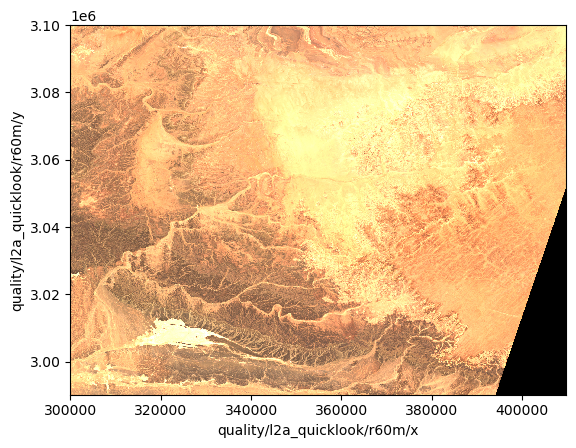

In [7]:
ds["quality/l2a_quicklook/r60m/tci"].plot.imshow(rgb="quality/l2a_quicklook/r60m/band")

:::{warning} Limitation
👉 You need to know where the file is!
:::

## But what if I don’t know the file?

Earth Observation (EO) data is massive — petabytes across satellites, sensors, and time ranges.

Manually finding files? Difficult. Painful.

We need a way to search and organize EO datasets by space, time, and metadata. In short, we need a **catalog**.

In EO, the de-facto standard for dataset catalogs is STAC.

STAC stands for SpatioTemporal Asset Catalog. It’s an open standard, developed by the community, for describing geospatial data — especially large EO datasets like Sentinel, Landsat, or commercial imagery.

**Key points:**

- Catalog of assets: A STAC is basically a JSON-based catalog that describes geospatial data (satellite images, derived products, etc.).
- Spatiotemporal: Each dataset (called an Item) has metadata about where (bounding box, geometry) and when (timestamp) it was acquired.
- Assets: The actual data files (e.g., GeoTIFFs, Cloud-optimized GeoTIFFs, NetCDF, Zarr) are linked as "assets" in the STAC Item.
- Collections: Items are grouped into collections (e.g., Sentinel-2 L2A).
- Catalogs: Collections can be organized hierarchically, enabling scalable discovery across petabytes of EO data.

```{figure} ../images/STAC_Diagram_Overview.png
:name: STAC Overview
:width: 800px
```

Let's access Sentinel-2 satellite imagery using a STAC (SpatioTemporal Asset Catalog) interface. Leveraging the `pystac-client`, `xarray`, and `matplotlib` libraries, the notebook demonstrates how to:

- Connect to a public EOPF STAC catalog hosted at [https://stac.core.eopf.eodc.eu](https://stac.core.eopf.eodc.eu).
- Perform structured searches across Sentinel-2 L2A collections, filtering by spatial extent, date range, cloud cover, and orbit characteristics.
- Retrieve and load data assets directly into xarray for interactive analysis.
- Visualize Sentinel-2 RGB composites along with pixel-level cloud coverage masks.


In [8]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
from pystac_client import CollectionSearch
from matplotlib.gridspec import GridSpec

In [9]:
# Initialize the collection search
search = CollectionSearch(
    url="https://stac.core.eopf.eodc.eu/collections",  # STAC /collections endpoint
)

# Retrieve all matching collections (as dictionaries)
for collection_dict in search.collections_as_dicts():
    print(collection_dict["id"])

sentinel-2-l2a
sentinel-3-olci-l2-lfr
sentinel-1-l2-ocn
sentinel-3-slstr-l2-lst
sentinel-1-l1-grd
sentinel-2-l1c
sentinel-1-l1-slc
sentinel-3-slstr-l1-rbt
sentinel-3-olci-l1-efr
sentinel-3-olci-l1-err
sentinel-3-olci-l2-lrr


## Sentinel-2 Item Search

Querying the Sentinel-2 L2A collection by bounding box, date range, and cloud cover

In [10]:
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
# Search with cloud cover filter
items = list(
    catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=[7.2, 44.5, 7.4, 44.7],
        datetime=["2025-01-30", "2025-05-01"],
        query={"eo:cloud_cover": {"lt": 20}},  # Cloud cover less than 20%
    ).items()
)
print(items)

[<Item id=S2B_MSIL2A_20250430T101559_N0511_R065_T32TLQ_20250430T131328>, <Item id=S2C_MSIL2A_20250425T102041_N0511_R065_T32TLQ_20250425T155812>, <Item id=S2C_MSIL2A_20250418T103041_N0511_R108_T32TLQ_20250418T160655>, <Item id=S2C_MSIL2A_20250405T102041_N0511_R065_T32TLQ_20250405T175414>]


## Quicklook Visualization for Sentinel-2
We can use the RGB quicklook layer contained in the Sentinel-2 EOPF Zarr product for a visualization of the content:

In [11]:
item = items[0]  # extracting the first item

ds = xr.open_dataset(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)  # The engine="eopf-zarr" is already embedded in the STAC metadata
ds

<xarray.Dataset> Size: 9GB
Dimensions:                                            (
                                                        conditions_geometry_angle: 2,
                                                        conditions_geometry_band: 13,
                                                        conditions_geometry_y: 23,
                                                        conditions_geometry_x: 23,
                                                        conditions_geometry_detector: 4,
                                                        ...
                                                        quality_mask_r20m_y: 5490,
                                                        quality_mask_r20m_x: 5490,
                                                        quality_mask_r60m_y: 1830,
                                                        quality_mask_r60m_x: 1830,
                                                        quality_probability_y: 5490,
                                                        quality_probability_x: 5490)
Coordinates: (12/63)
  * conditions_geometry_angle                          (conditions_geometry_angle) <U7 56B ...
  * conditions_geometry_band                           (conditions_geometry_band) <U3 156B ...
  * conditions_geometry_detector                       (conditions_geometry_detector) int64 32B ...
  * conditions_geometry_x                              (conditions_geometry_x) int64 184B ...
  * conditions_geometry_y                              (conditions_geometry_y) int64 184B ...
  * conditions_mask_detector_footprint_r10m_x          (conditions_mask_detector_footprint_r10m_x) int64 88kB ...
    ...                                                 ...
  * quality_mask_r20m_y                                (quality_mask_r20m_y) int64 44kB ...
  * quality_mask_r60m_x                                (quality_mask_r60m_x) int64 15kB ...
  * quality_mask_r60m_y                                (quality_mask_r60m_y) int64 15kB ...
    quality_probability_band                           int64 8B ...
  * quality_probability_x                              (quality_probability_x) int64 44kB ...
  * quality_probability_y                              (quality_probability_y) int64 44kB ...
Data variables: (12/86)
    conditions_geometry_mean_sun_angles                (conditions_geometry_angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    conditions_geometry_mean_viewing_incidence_angles  (conditions_geometry_band, conditions_geometry_angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
    conditions_geometry_sun_angles                     (conditions_geometry_angle, conditions_geometry_y, conditions_geometry_x) float64 8kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
    conditions_geometry_viewing_incidence_angles       (conditions_geometry_band, conditions_geometry_detector, conditions_geometry_angle, conditions_geometry_y, conditions_geometry_x) float64 440kB dask.array<chunksize=(7, 4, 2, 23, 23), meta=np.ndarray>
    conditions_mask_detector_footprint_r10m_b02        (conditions_mask_detector_footprint_r10m_y, conditions_mask_detector_footprint_r10m_x) uint8 121MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    conditions_mask_detector_footprint_r10m_b03        (conditions_mask_detector_footprint_r10m_y, conditions_mask_detector_footprint_r10m_x) uint8 121MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    ...                                                 ...
    quality_mask_r20m_b8a                              (quality_mask_r20m_y, quality_mask_r20m_x) uint8 30MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    quality_mask_r60m_b01                              (quality_mask_r60m_y, quality_mask_r60m_x) uint8 3MB dask.array<chunksize=(305, 305), meta=np.ndarray>
    quality_mask_r60m_b09                              (quality_mask_r60m_y, quality_mask_r60m_x) uint8 3MB dask.array<chunksize=(305, 305), meta=np.ndar

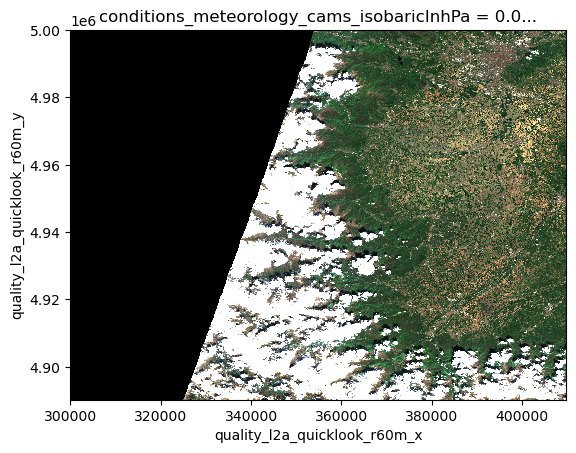

In [12]:
ds.quality_l2a_quicklook_r60m_tci.plot.imshow(rgb="quality_l2a_quicklook_r60m_band")

## There isn’t just one STAC catalog
There are many STAC catalogs, each hosting different collections of datasets. A collection groups related assets, such as all Sentinel-2 images for a region, or all Landsat scenes for a certain period. By browsing catalogs and their collections, users can quickly find the data they need without hunting through petabytes of raw files.

The STAC catalog at https://earth-search.aws.element84.com/v1 is provided by Element 84 and offers a centralized search interface for various geospatial datasets hosted on AWS. This catalog is part of the Earth Search project, which is designed to facilitate access to open geospatial data through a standardized SpatioTemporal Asset Catalog (STAC) API.

In [13]:
import stackstac

In [14]:
#                West, South, East, North
spatial_extent = [11.1, 46.1, 11.5, 46.5]
temporal_extent = ["2015-01-01","2022-01-01"]

**Running this cell may take up to 2 minutes**

In [15]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

# Search Sentinel-2 L2A items
items = catalog.search(
    bbox=spatial_extent,
    datetime=temporal_extent,
    collections=["sentinel-2-l2a"]
).item_collection()

Calling  `stackstac.stack()` method for the `items`, the data will be lazily loaded and an `xArray.DataArray` object returned.

Running the next cell will show the selected data content with the dimension names and their extent.

In [16]:
# Stack into a datacube
datacube = stackstac.stack(
    items,
    bounds_latlon=spatial_extent,
    epsg=32632,        # UTM zone for tile 32N
    resolution=10,     # 10m pixels
    chunksize=4096     # optional, improves performance
)

datacube

<xarray.DataArray 'stackstac-6820bbacf43f782d94d9a1563f88a8ac' (time: 966,
                                                                band: 32,
                                                                y: 4535, x: 3210)> Size: 4TB
dask.array<fetch_raster_window, shape=(966, 32, 4535, 3210), dtype=float64, chunksize=(1, 1, 4096, 3210), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 8kB 2016-1...
    id                                       (time) <U24 93kB 'S2A_32TPS_2016...
  * band                                     (band) <U12 2kB 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 26kB 6.611e+05 ... 6...
  * y                                        (y) float64 36kB 5.153e+06 ... 5...
    s2:high_proba_clouds_percentage          (time) object 8kB 24.661314 ... ...
    ...                                       ...
    title                                    (band) <U31 4kB 'Aerosol optical...
    gsd                                      (band) object 256B None 10 ... None
    common_name                              (band) object 256B None ... None
    center_wavelength                        (band) object 256B None ... None
    full_width_half_max                      (band) object 256B None ... None
    epsg                                     int64 8B 32632
Attributes: (4)

From the output of the previous cell you can notice something really interesting: **the size of the selected data is more than 3 TB!**

But you should have noticed that it was too quick to download this huge amount of data.

This is what lazy loading allows: getting all the information about the data in a quick manner without having to access and download all the available files.

**Quiz hint: look carefully at the dimensions of the loaded datacube!**

## Data Formats and Performance

### Chunking Explained

When working with large Earth Observation datasets, it’s usually not possible to load all data into a computer’s memory at once. Instead, data is divided into smaller, manageable chunks. Each chunk is the smallest unit that can be processed independently. This chunking strategy enables efficient, piecewise data access and parallel processing, improving performance and scalability.

The figure below visually explains the concept of data chunking: on the left, a three-dimensional data cube (x, y, and time) is shown without chunks, while on the right, the same data cube is displayed with chunks highlighted.


| Data Cube without chunking                                         |                                   Data Cube with chunking |
| ---------------------------------------------------------------- | ------------------------------------------------------- |
| ![No Chunking](https://raw.githubusercontent.com/EO-College/cubes-and-clouds/refs/heads/main/lectures/2.4_formats_and_performance/exercises/assets/notchunked.png "Data Cube without chunking") | ![Chunking](https://raw.githubusercontent.com/EO-College/cubes-and-clouds/refs/heads/main/lectures/2.4_formats_and_performance/exercises/assets/chunked.png "Data Cube with chunking") |

> Figure: on the left, a 3D data cube without any chunking strategy applied. On the right, a 3D data cube with box chunking.


There are several ways to chunk data depending on the analysis needs:

- Spatial chunking divides data by geographic regions (e.g., longitude and latitude), ideal for spatial queries.
- Time-based chunking divides datasets along temporal dimensions, useful for time series analysis.
- Box chunking partitions data into fixed-size, 3D blocks combining space and time.

Choosing an appropriate chunking strategy is crucial, as it impacts read performance, memory usage, and cost-effectiveness in cloud environments.

## Q&A: What Did You Discover?
*3 minutes*

**Key Concepts Participants Should Understand:**
1. **Memory Efficiency**: Chunking enables processing datasets larger than RAM
3. **Lazy Evaluation**: Build complex operations without immediate computation
4. **Cloud-Native**: Stream only needed data chunks from remote storage
5. **Scalability**: Same patterns work from laptop to supercomputer

**Questions for Understanding:**
- "How does chunking solve the 'big data' problem?"
- "Why is lazy evaluation important for satellite data analysis?"

The demo below uses the Pangeo ecosystem to access and process data.

:::{note} The Pangeo ecosystem
Pangeo is a Community-Driven Approach to Advancing Open Source Earth Observation Tools Across Disciplines.

```{figure} ../images/PangeoEurope.png
:name: The Pangeo ecosystem
:width: 950px
```
:::